In [1]:
import jax.numpy as jnp
import b3d
import os
import trimesh
import matplotlib.pyplot as plt
import jax
import numpy as np

In [2]:
mesh_path = os.path.join(
    b3d.get_root_path(), "assets/shared_data_bucket/025_mug/textured.obj"
)
mesh = trimesh.load(mesh_path)
mesh.vertices = mesh.vertices - mesh.vertices.mean(axis=0)

object_library = b3d.MeshLibrary.make_empty_library()
object_library.add_trimesh(mesh)

/opt/conda/envs/b3d/lib/python3.11/site-packages/trimesh/grouping.py:99: RuntimeWarning: invalid value encountered in cast
  stacked = np.column_stack(stacked).round().astype(np.int64)


In [3]:
h,w,fx,fy,cx,cy = 50, 50, 100.0, 100.0, 25.0, 25.0
renderers = [
    b3d.RendererOriginal(scale * h, scale *w, scale * fx, scale * fy, scale * cx, scale * cy, 0.01, 10.0)
    for scale in [9]
]

In [4]:
def gaussian_logpdf(obs_image, rendered_image,b, multiplier, a, outlier_prob):
    probabilities = jax.scipy.stats.norm.logpdf(
        obs_image, rendered_image, multiplier
    )
    probabilities_adjusted = jnp.logaddexp(
        probabilities + jnp.log(1.0 - outlier_prob),
        jnp.log(outlier_prob)
    )
    return probabilities_adjusted.sum()

def gaussian_sample(key, rendered_image, b,multiplier, a, outlier_prob):
    return jax.random.normal(
        key, shape=rendered_image.shape
    ) * multiplier + rendered_image


def new_logpdf(observed_rgb, rendered_rgb, rendered_depth, multiplier, color_tolerance, outlier_prob):
    observed_lab = b3d.rgb_to_lab(observed_rgb)
    rendered_lab = b3d.rgb_to_lab(rendered_rgb)
    error = (
        jnp.linalg.norm(observed_lab[...,1:3] - rendered_lab[...,1:3], axis=-1) + 
        jnp.abs(observed_lab[...,0] - rendered_lab[...,0])
    )

    valid_data_mask = (rendered_rgb.sum(-1) != 0.0)

    color_inliers = (error < color_tolerance) * valid_data_mask
    inliers = color_inliers
    outliers = jnp.logical_not(inliers) * valid_data_mask
    undecided = jnp.logical_not(inliers) * jnp.logical_not(outliers)

    corrected_depth = rendered_depth + (rendered_depth == 0.0) * 1.0
    areas = (corrected_depth / fx) * (corrected_depth / fy)

    inlier_score = 4.0
    return jnp.log(
        # This is leaving out a 1/A (which does depend upon the scene)
        inlier_score * jnp.sum(inliers * areas) +
        1.0 * jnp.sum(undecided * areas)  +
        outlier_prob * jnp.sum(outliers * areas)
    ) * multiplier


In [5]:
def new_ray_outlier_logpdf(observed_rgb, observed_depth, rendered_rgb, rendered_depth, multiplier, color_tolerance, depth_tolerance, ray_outlier_prob):
    observed_lab = b3d.rgb_to_lab(observed_rgb)
    rendered_lab = b3d.rgb_to_lab(rendered_rgb)
    color_error = (
        jnp.linalg.norm(observed_lab[...,1:3] - rendered_lab[...,1:3], axis=-1) + 
        jnp.abs(observed_lab[...,0] - rendered_lab[...,0])
    )
    depth_error = jnp.abs(observed_depth - rendered_depth)

    valid_data_mask = (rendered_rgb.sum(-1) != 0.0)

    color_inliers = (color_error < color_tolerance) * valid_data_mask
    depth_inliers = (depth_error < depth_tolerance) * valid_data_mask
    inliers = color_inliers * depth_inliers 

    rendered_areas = (rendered_depth / fx) * (rendered_depth / fy)
    observed_areas = (observed_depth / fx) * (observed_depth / fy)

    inlier_noise_density = 1/(2*color_tolerance)
    inlier_branch_score = 1/jnp.sum(rendered_areas) * (inlier_noise_density * jnp.sum(inliers * rendered_areas))

    outlier_noise_density = 1/(2*depth_tolerance)
    depth_max = 20
    V = 1/3 * jnp.power(depth_max, 3) * h * w * 1/(fx * fy)
    outlier_branch_score = 1/V * jnp.sum(observed_areas) * outlier_noise_density
    return jnp.log((1-ray_outlier_prob) *  inlier_branch_score + ray_outlier_prob * outlier_branch_score) * multiplier

In [6]:
linear_pose_from_points = lambda points1, points2, alpha: b3d.Pose.from_position_and_target(
    jnp.array([0.0, -0.8, 0.1]),
    jnp.zeros(3)
).inv() @ b3d.Pose.from_translation((1 - alpha) * points1 + alpha * points2 )

In [7]:
point1 = jnp.array([-0.05,-0.25,0])
point2 = jnp.array([0.2,1.5,0])

In [8]:
alphas = jnp.linspace(-0.05, 1.5, 41)
vec_fun = jax.vmap(linear_pose_from_points, (None, None, 0))


In [9]:
linear_poses = vec_fun(point1, point2, alphas)
transformed_vertices = jax.vmap(lambda i: linear_poses[i].apply(object_library.vertices))(jnp.arange(len(linear_poses)))

In [10]:
def render_rgbd_many(renderer, vertices, faces, attributes):
    return renderer.render_many(
        transformed_vertices,
        object_library.faces,
        jnp.concatenate([attributes, transformed_vertices[...,-1:]],axis=-1)
    )

In [11]:
N = len(linear_poses)

all_images = [
        render_rgbd_many(r,
        transformed_vertices,
        object_library.faces,
        jnp.tile(object_library.attributes, (N,1,1)),
    )
    for r in renderers
]


images = all_images[0]
gt_image = images[0]


In [12]:
gt_near_ind = len(alphas)//6
gt_far_ind = 4*len(alphas)//6
gt_image = images[gt_near_ind,...,:3] + images[gt_far_ind,...,:3]
gt_image_depth = np.array(images[gt_near_ind,...,3] + images[gt_far_ind,...,3])
gt_image_depth[gt_image_depth==0] = 16.0
gt_image_depth = jnp.array(gt_image_depth)

Text(0, 0.5, 'Posterior Probability')

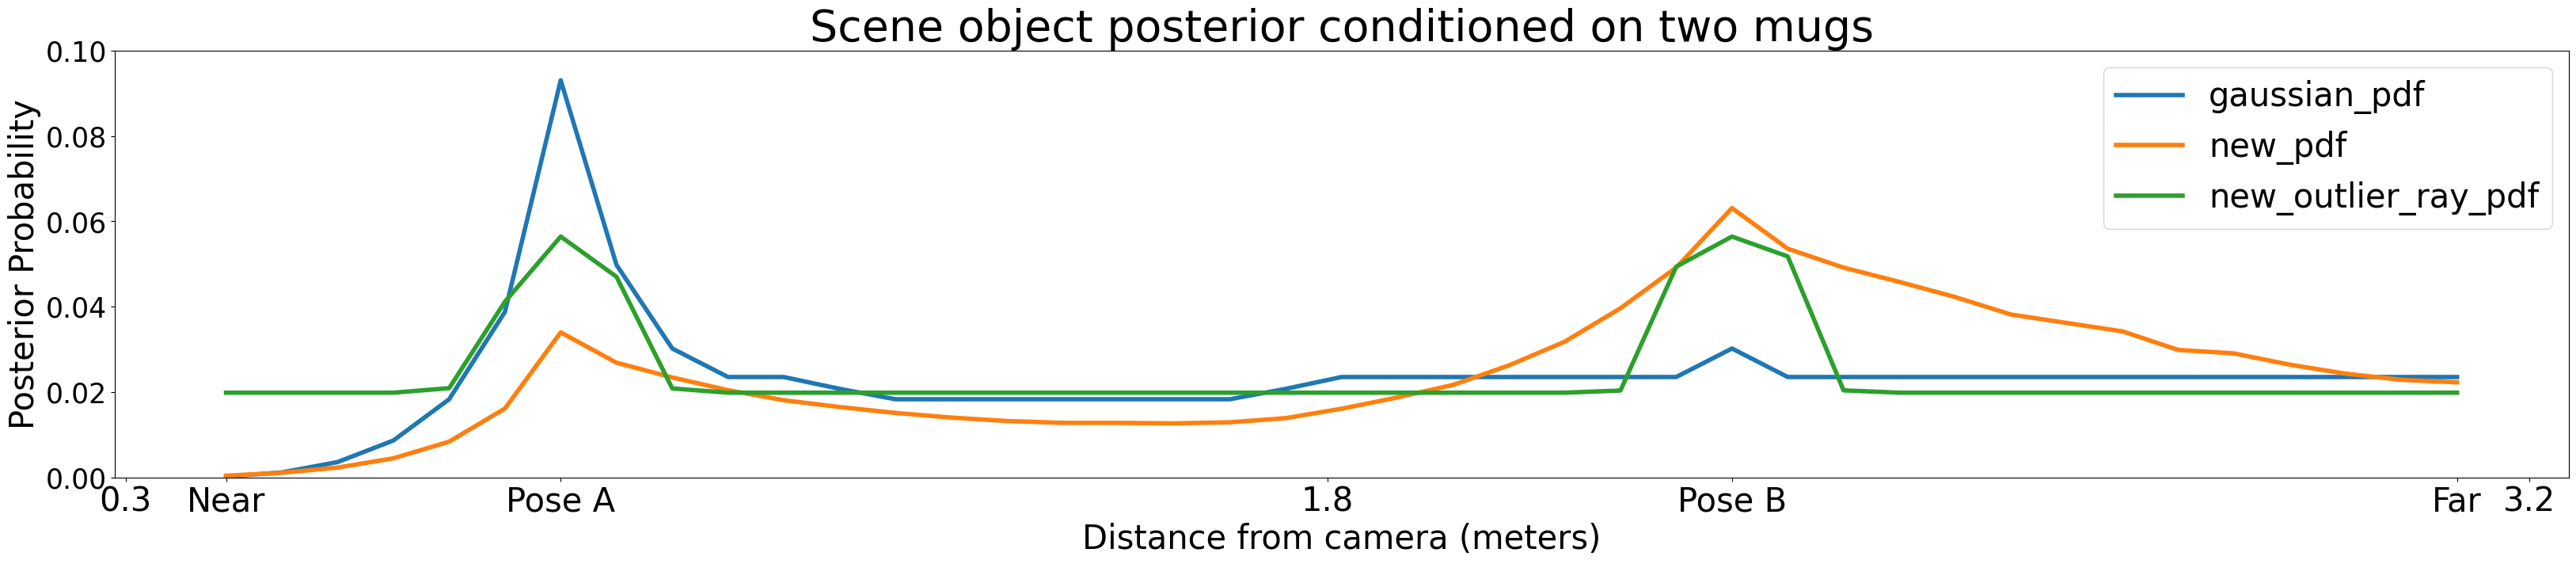

In [19]:
multiplier_a = 13
multiplier_b = 20.0


variance_color = 50.0
variance_depth = 0.1
outlier_prob =  0.1
ray_outlier_prob = 0.005 

gaussian_logpdfs = jax.vmap(gaussian_logpdf, in_axes=(None, 0, 0, None, None, None))(gt_image,
                                                                        images[...,:3], images[...,3], multiplier_a, variance_color, outlier_prob)
new_logpdfs = jax.vmap(new_logpdf, in_axes=(None, 0, 0, None, None, None))(gt_image,
                                                                           images[...,:3], images[...,3], multiplier_b, variance_color, outlier_prob)
# (observed_rgb, observed_depth, rendered_rgb, rendered_depth, multiplier, color_tolerance, outlier_prob, ray_outlier_prob):
new_ray_outlier_logpdfs = jax.vmap(new_ray_outlier_logpdf, in_axes=(None, None, 0, 0, None, None, None, None))(gt_image, gt_image_depth,
                                                                           images[...,:3], images[...,3], multiplier_b, variance_color, variance_depth, ray_outlier_prob)




fig, axes = plt.subplots(1, 1, figsize=(40, 7))
distances = linear_poses.pos[:,2]
axes.plot(distances, b3d.normalize_log_scores(gaussian_logpdfs), alpha=1, linewidth=4, label='gaussian_pdf')
axes.plot(distances, b3d.normalize_log_scores(new_logpdfs), alpha=1, linewidth=4, label='new_pdf')
axes.plot(distances, b3d.normalize_log_scores(new_ray_outlier_logpdfs), alpha=1, linewidth=4, label='new_outlier_ray_pdf')
num_ticks = 3

xticks = list(np.linspace(0.35, 3.25, num_ticks))
axes.set_xticks(xticks + [linear_poses.pos[gt_near_ind,2], linear_poses.pos[gt_far_ind,2], 
                          linear_poses.pos[0,2], linear_poses.pos[-1,2]])
axes.set_xticklabels(['%.1f' % f for f in xticks] + ['Pose A', 'Pose B', 'Near', 'Far'], fontsize=30)
axes.tick_params(axis='y', labelsize=25)
axes.set_ylim(0.0, 0.1)

title = "Scene object posterior conditioned on two mugs"
plt.title(title, fontsize=40)
plt.legend(fontsize=30)
# alpha value: pose = (1 - alpha) * point1 + alpha * point2
plt.xlabel("Distance from camera (meters)", fontsize=30)
plt.ylabel("Posterior Probability", fontsize=30)


Text(0, 0.5, 'Posterior Probability')

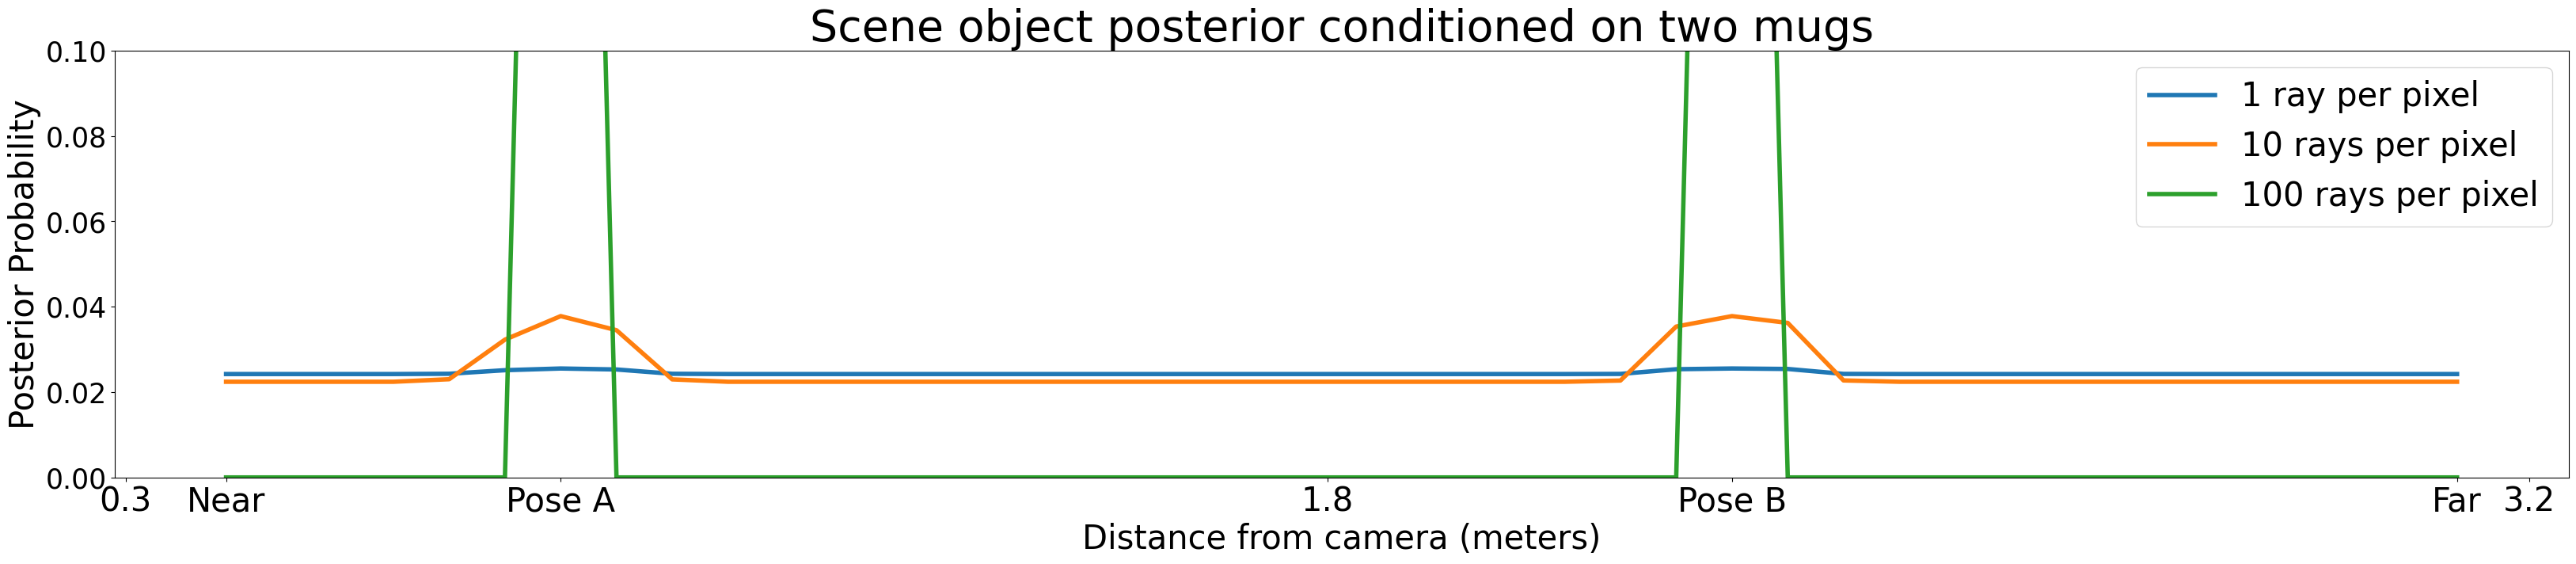

In [20]:
multiplier_b = jnp.array([1.0,10.0,10000.0])

ray_outlier_prob = 0.005

mapped_evaluate =  jax.vmap(jax.vmap(new_ray_outlier_logpdf, in_axes=(None, None, 0, 0, None, None, None, None)), (None, None, None, None, 0, None, None, None))
new_ray_outlier_logpdfs = mapped_evaluate(gt_image, gt_image_depth, images[...,:3], images[...,3], multiplier_b, variance_color, variance_depth, ray_outlier_prob)


fig, axes = plt.subplots(1, 1, figsize=(40, 7))
distances = linear_poses.pos[:,2]
axes.plot(distances, b3d.normalize_log_scores(new_ray_outlier_logpdfs[0]), alpha=1, linewidth=4, label='1 ray per pixel')
axes.plot(distances, b3d.normalize_log_scores(new_ray_outlier_logpdfs[1]), alpha=1, linewidth=4, label='10 rays per pixel')
axes.plot(distances, b3d.normalize_log_scores(new_ray_outlier_logpdfs[2]), alpha=1, linewidth=4, label='100 rays per pixel')
num_ticks = 3

xticks = list(np.linspace(0.35, 3.25, num_ticks))
axes.set_xticks(xticks + [linear_poses.pos[gt_near_ind,2], linear_poses.pos[gt_far_ind,2], 
                          linear_poses.pos[0,2], linear_poses.pos[-1,2]])
axes.set_xticklabels(['%.1f' % f for f in xticks] + ['Pose A', 'Pose B', 'Near', 'Far'], fontsize=30)
axes.tick_params(axis='y', labelsize=25)
axes.set_ylim(0.0, 0.1)

title = "Scene object posterior conditioned on two mugs"
plt.title(title, fontsize=40)
plt.legend(fontsize=30)
# alpha value: pose = (1 - alpha) * point1 + alpha * point2
plt.xlabel("Distance from camera (meters)", fontsize=30)
plt.ylabel("Posterior Probability", fontsize=30)


Text(0, 0.5, 'Posterior Probability')

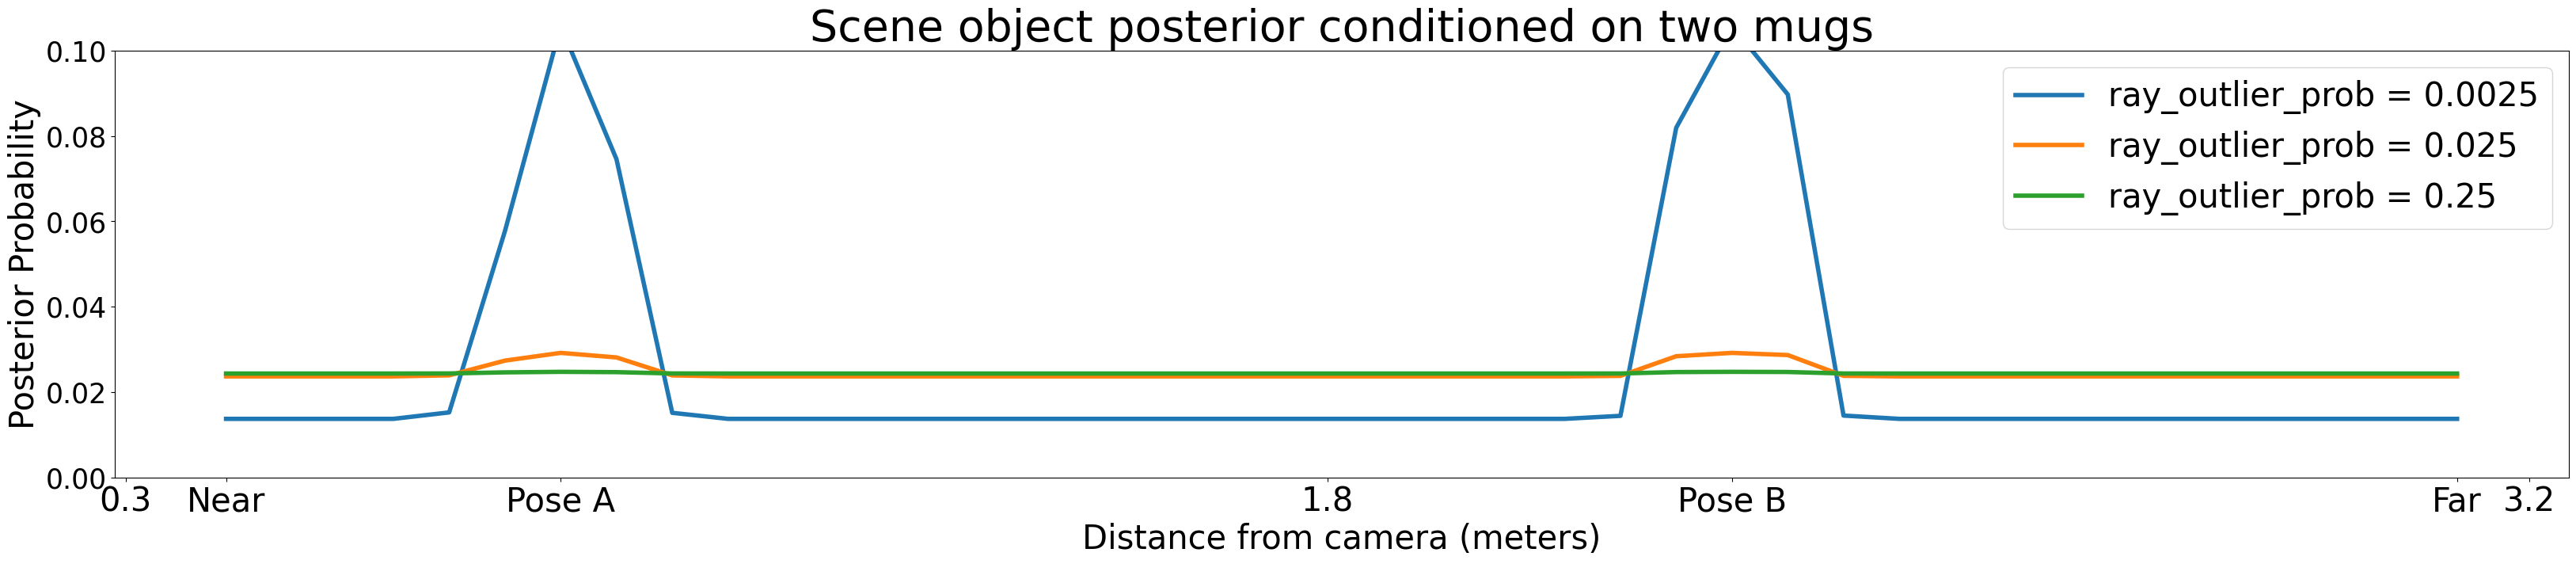

In [21]:
multiplier_a = 13
multiplier_b = 20.0


ray_outlier_prob = jnp.array([0.0025, 0.025, 0.25])

mapped_evaluate =  jax.vmap(jax.vmap(new_ray_outlier_logpdf, in_axes=(None, None, 0, 0, None, None, None, None)), (None, None, None, None, None, None, None, 0))
new_ray_outlier_logpdfs = mapped_evaluate(gt_image, gt_image_depth, images[...,:3], images[...,3], multiplier_b, variance_color, variance_depth, ray_outlier_prob)


fig, axes = plt.subplots(1, 1, figsize=(40, 7))
distances = linear_poses.pos[:,2]
axes.plot(distances, b3d.normalize_log_scores(new_ray_outlier_logpdfs[0]), alpha=1, linewidth=4, label='ray_outlier_prob = 0.0025')
axes.plot(distances, b3d.normalize_log_scores(new_ray_outlier_logpdfs[1]), alpha=1, linewidth=4, label='ray_outlier_prob = 0.025')
axes.plot(distances, b3d.normalize_log_scores(new_ray_outlier_logpdfs[2]), alpha=1, linewidth=4, label='ray_outlier_prob = 0.25')
num_ticks = 3

xticks = list(np.linspace(0.35, 3.25, num_ticks))
axes.set_xticks(xticks + [linear_poses.pos[gt_near_ind,2], linear_poses.pos[gt_far_ind,2], 
                          linear_poses.pos[0,2], linear_poses.pos[-1,2]])
axes.set_xticklabels(['%.1f' % f for f in xticks] + ['Pose A', 'Pose B', 'Near', 'Far'], fontsize=30)
axes.tick_params(axis='y', labelsize=25)
axes.set_ylim(0.0, 0.1)

title = "Scene object posterior conditioned on two mugs"
plt.title(title, fontsize=40)
plt.legend(fontsize=30)
# alpha value: pose = (1 - alpha) * point1 + alpha * point2
plt.xlabel("Distance from camera (meters)", fontsize=30)
plt.ylabel("Posterior Probability", fontsize=30)


In [ ]:
# posterior with sub 1-ray per pixel



def new_ray_outlier_logpdf_sub(observed_rgb, observed_depth, rendered_rgb, rendered_depth, frac, color_tolerance, depth_tolerance, ray_outlier_prob):
    observed_lab = b3d.rgb_to_lab(observed_rgb)
    rendered_lab = b3d.rgb_to_lab(rendered_rgb)
    color_error = (
        jnp.linalg.norm(observed_lab[...,1:3] - rendered_lab[...,1:3], axis=-1) + 
        jnp.abs(observed_lab[...,0] - rendered_lab[...,0])
    )
    depth_error = jnp.abs(observed_depth - rendered_depth)

    valid_data_mask = (rendered_rgb.sum(-1) != 0.0)

    color_inliers = (color_error < color_tolerance) * valid_data_mask
    depth_inliers = (depth_error < depth_tolerance) * valid_data_mask
    inliers = color_inliers * depth_inliers # sample inlier pixels

    rendered_areas = (rendered_depth / fx) * (rendered_depth / fy)
    observed_areas = (observed_depth / fx) * (observed_depth / fy)

    key = jax.random.key(0)
    mask = jax.random.choice(key, jnp.array([0,1]), rendered_areas.shape, p=jnp.array([1-frac, frac]))

    inlier_noise_density = 1/(2*color_tolerance)
    inlier_branch_score = 1/jnp.sum(rendered_areas) * (inlier_noise_density * jnp.sum(inliers * rendered_areas))

    outlier_noise_density = 1/(2*depth_tolerance)
    depth_max = 20
    V = 1/3 * jnp.power(depth_max, 3) * h * w * 1/(fx * fy)
    outlier_branch_score = 1/V * jnp.sum(observed_areas) * outlier_noise_density
    
    return jnp.log((1-ray_outlier_prob) *  inlier_branch_score + ray_outlier_prob * outlier_branch_score)


Text(0, 0.5, 'Posterior Probability')

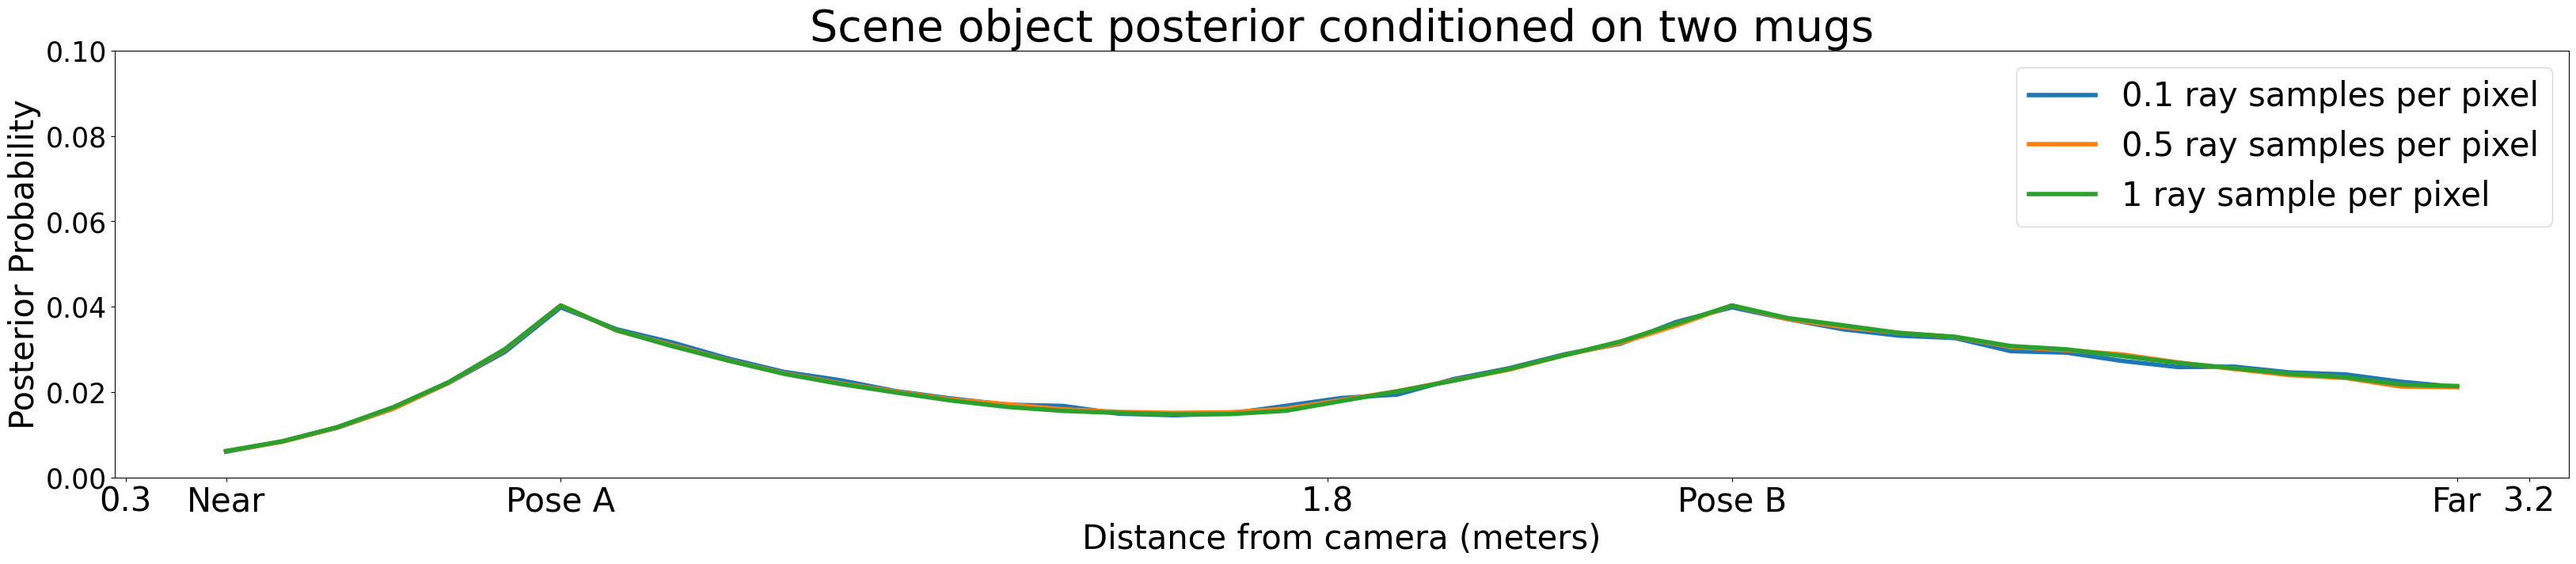

In [ ]:
multiplier_b = jnp.array([0.1,0.5,1.0])


ray_outlier_prob = 0.025

mapped_evaluate =  jax.vmap(jax.vmap(new_ray_outlier_logpdf_sub, in_axes=(None, None, 0, 0, None, None, None, None)), (None, None, None, None, 0, None, None, None))
new_ray_outlier_logpdfs = mapped_evaluate(gt_image, gt_image_depth, images[...,:3], images[...,3], multiplier_b, variance_color, variance_depth, ray_outlier_prob)


fig, axes = plt.subplots(1, 1, figsize=(40, 7))
distances = linear_poses.pos[:,2]
axes.plot(distances, b3d.normalize_log_scores(new_ray_outlier_logpdfs[0]), alpha=1, linewidth=4, label='0.1 ray samples per pixel')
axes.plot(distances, b3d.normalize_log_scores(new_ray_outlier_logpdfs[1]), alpha=1, linewidth=4, label='0.5 ray samples per pixel')
axes.plot(distances, b3d.normalize_log_scores(new_ray_outlier_logpdfs[2]), alpha=1, linewidth=4, label='1 ray sample per pixel')
num_ticks = 3

xticks = list(np.linspace(0.35, 3.25, num_ticks))
axes.set_xticks(xticks + [linear_poses.pos[gt_near_ind,2], linear_poses.pos[gt_far_ind,2], 
                          linear_poses.pos[0,2], linear_poses.pos[-1,2]])
axes.set_xticklabels(['%.1f' % f for f in xticks] + ['Pose A', 'Pose B', 'Near', 'Far'], fontsize=30)
axes.tick_params(axis='y', labelsize=25)
axes.set_ylim(0.0, 0.1)

title = "Scene object posterior conditioned on two mugs"
plt.title(title, fontsize=40)
plt.legend(fontsize=30)
# alpha value: pose = (1 - alpha) * point1 + alpha * point2
plt.xlabel("Distance from camera (meters)", fontsize=30)
plt.ylabel("Posterior Probability", fontsize=30)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


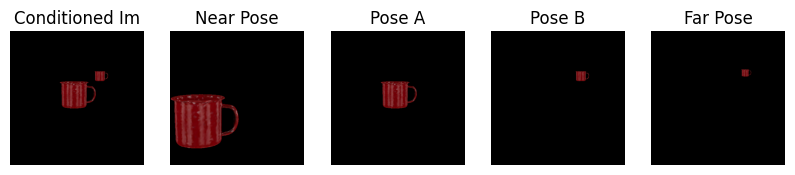

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(151)
ax1.imshow(gt_image[...,:3])
ax1.axis('off')

ax2 = fig.add_subplot(152)
ax2.imshow(images[0,...,:3])
ax2.axis('off')

ax3 = fig.add_subplot(153)
ax3.imshow(images[gt_near_ind,...,:3])
ax3.axis('off')

ax4 = fig.add_subplot(154)
ax4.imshow(images[gt_far_ind,...,:3])
ax4.axis('off')

ax5 = fig.add_subplot(155)
ax5.imshow(images[-1,...,:3])
ax5.axis('off')

ax1.title.set_text('Conditioned Im')
ax2.title.set_text('Near Pose')
ax3.title.set_text('Pose A')
ax4.title.set_text('Pose B')
ax5.title.set_text('Far Pose')
plt.show()

In [ ]:
# does new likelihood fail size invariance test

In [ ]:
# HERE!!!: see if shout patch tracking scales under this model

In [ ]:
# view angle invariance posterior test as described with nishad